### Усложняем динамику для Gravity_lens

Теперь:
r''_FCS = u_FCS - a_FCS - S^T * (S'' * r_FCS + 2 * S' * r'_FCS)

In [32]:
# !pip install stable_baselines3
# !pip install numpy


In [1]:
import sys
sys.path.append("C:/Users/snr/kiam_rl")

from datetime import datetime
import stable_baselines3
from rl_routines import RLProblem, Environment
from rl_routines import ActorCriticNetworks, get_CustomActorCriticPolicy
from rl_routines import evaluate_policy, statistics
import gymnasium as gym
import numpy 
from numpy.linalg import norm
from stable_baselines3 import PPO
import torch
import math
import random
import matplotlib.pyplot as plt
import os
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from torch.utils.tensorboard import SummaryWriter
from scipy.integrate import solve_ivp

In [2]:
from Dynamics_SGLF import Dynamics_SGLF


In [35]:
# Единицы измерения
DU = 100_000. # в км
TU = 1e5 # в сек, примерно 27.(7) часов
VU = DU / TU # в км/сек

In [36]:
""" параметры задачи """
R0 = 100_000. / DU #радиус круга, который является областью начальных условий;
z0 = 10 * 9.461e+12 / DU # начало движения КА вдоль фокальной линии на расстоянии 10св лет от Солнца
tfinal = 30. * 24. * 60. * 60. / TU # длительность эпизода 
n_imp = 6 # число импульсов за эпизод
delta_t_imp = tfinal / n_imp # интервал между импульсами
delta_v_max = 0.1 / VU # ограничение импульсов
alfa = 1. # весовая константа в выражении для функции вознаграждения
threshold = 10_000. / DU # радиус круга-цели на плоскости Oyx
total_timesteps = 500 # общее количество шагов во время обучения модели
t0 = 0.
a_vec = numpy.array([1., 0., 0.]) # произвольный постоянный вектор в SSB, который никогда не коллинеарен фокальной линии (вектору n0)
Orb_param_exo_array = numpy.array([1.* 1.496e+8 / DU, 1. * 3.156e+7/ TU , 0.0167086, -240., 352.5, 37.5, datetime(2021, 1, 2) ])   # [a(AU) * 1.496e+8 / DU, T(yr * 3.156e+7 seconds / TU), e, Omega(grad), w(grad), i(grad), t0]

M_sun = 1.989*1e30 # масса Солнца (кг)

M_JSUN_array = numpy.array([1.8982*1e27, 5.6834*1e26, 8.6810 * 1e25, 1.02413*1e26]) # массы Юпитера, Сатурна, Урана, Нептуна (в кг)

Orb_param_JSUN_array = numpy.array([
    [5.2044 * DU, 11.862 * TU, 0.0489, 100.464, 273.867, 1.303, (datetime(2023, 1, 21) - datetime(2000, 1, 1)).total_seconds()],  
    [9.5826 * DU, 29.4571 * TU, 0.0565, 113.665, 339.392, 2.485, (datetime(2032, 11, 29) - datetime(2000, 1, 1)).total_seconds()],  
    [19.2184 * DU, 84.0205 * TU, 0.046381, 74.006, 96.998857, 0.773, (datetime(2050, 8, 19) - datetime(2000, 1, 1)).total_seconds()],  
    [30.07 * DU, 164.8 * TU, 0.008678, 131.784, 276.336, 1.767957, (datetime(2042, 9, 4) - datetime(2000, 1, 1)).total_seconds()]  
])
 # орбитальные параметры Юпитера, Сатурна, Урана, Нептуна


In [37]:
class Dynamics_Problem(RLProblem):
    def __init__(self, R0, tfinal, n_imp, delta_t_imp, delta_v_max, alfa, threshold, a_vec, Orb_param_exo_array, M_sun, M_JSUN_array, Orb_param_JSUN_array, t0, z0):
        """
        единица расстояния: 100_000 км
        единица скорости: 1 км/сек
        единица времени: 100_000 сек
        """
        super().__init__()
        self.R0 = R0
        self.tfinal = tfinal
        self.n_imp = n_imp
        self.delta_t_imp = delta_t_imp
        self.delta_v_max = delta_v_max
        self.alfa = alfa
        self.threshold = threshold
        self.time_step = self.tfinal / self.n_imp
        self.a_vec = a_vec
        self.Orb_param_exo_array = Orb_param_exo_array
        self.M_sun = M_sun
        self.M_JSUN_array = M_JSUN_array
        self.Orb_param_JSUN_array = Orb_param_JSUN_array
        self.t0 = t0
        self.z0 = z0
        self.nostep = 0 
        
    @property
    def observation_space(self):  
        return gym.spaces.Box(low=numpy.array([self.t0, -numpy.inf, -numpy.inf, -numpy.inf, -numpy.inf, -numpy.inf, -numpy.inf]),  
                              high=numpy.array([self.tfinal, numpy.inf , numpy.inf, numpy.inf, numpy.inf, numpy.inf, numpy.inf]), 
                              dtype=numpy.float64)
    
    @property
    def action_space(self):  
        return gym.spaces.Box(low=-1, high=1, shape=(3,), dtype=numpy.float32)
    
    def initialize(self):
        """
        Инициализация начального положения и времени.
        Генерация начального состояния аппарата в соответствии с условиями:
        r0 = [0, y0, z0], v0 = [0, 0, 0], где y0^2 + z0^2 ≤ R0^2.
        """
        self.nostep = 0
        while True:
            x0 = numpy.random.uniform(-self.R0, self.R0) 
            y0 = numpy.random.uniform(-self.R0, self.R0)
            if x0**2 + y0**2 <= self.R0**2:
                break
        x0 = numpy.array([x0, y0, self.z0, 0., 0., 0.])  # Фазовый вектор размерности (6,)
        t_init = numpy.random.uniform(self.t0, self.tfinal)  
        self.x_old = x0.copy()
        return t_init, x0
    
    def action2u(self, action):
        """
        Функция, переводящая выход стратегии (нейросети) в импульс.
        """
        delta_v = action * min(1, self.delta_v_max / numpy.linalg.norm(action))
        return delta_v
    
    def Dynamics(self, t):
        """
        Возвращает матрицу S и вторую производную по времени от r_sun.
        """
        dynamics = Dynamics_SGLF(self.Orb_param_exo_array, self.M_sun, self.M_JSUN_array, self.Orb_param_JSUN_array, self.t0, self.a_vec, self.z0)
        dr_sun_dt, d2r_sun_dt = dynamics.r_sun_deriv(t)  
        S = dynamics.basis_FCS(t)  
        dS_dt, d2S_dt = dynamics.dS_dt(t)  
        return S, dS_dt, d2S_dt, d2r_sun_dt

    def equations_of_motion(self, t, x):
        """
        Возвращает правую часть уравнений движения в системе FCS без учета импульса.
        """
        S, dS_dt, d2S_dt, d2r_sun_dt = self.Dynamics(t) 

        r_SSB = x[:3]
        v_SSB = x[3:]

        r_FCS = numpy.matmul(S.T, r_SSB)
        v_FCS = numpy.matmul(S.T, v_SSB)

        D = numpy.matmul(d2S_dt, r_FCS) + 2 * numpy.matmul(dS_dt, v_FCS)
        d2_r_FCS_dt = -d2r_sun_dt - numpy.matmul(S.T, D)

        return numpy.concatenate([v_FCS, d2_r_FCS_dt])

    def step(self, t, x, delta_v):
        """
        Шаг моделирования: агент применяет импульс, и состояние обновляется.
        """
        self.x_old = x.copy()
        self.nostep += 1
        x_new = x.copy().astype(numpy.float64)  # Гарантируем, что x_new будет массивом float64
        
        # Применяем изменение скорости
        x_new[3:6] += delta_v  
        
        # Численное интегрирование
        sol = solve_ivp(self.equations_of_motion, (t, t + self.time_step), x_new, method='RK45', t_eval=[t + self.time_step])

        x_new = sol.y[:, -1].reshape(-1)  # Принудительно делаем одномерным

        terminated = False
        truncated = self.nostep >= self.n_imp 

        return t + self.time_step, x_new, terminated, truncated

    def rho(self, x):
        """Вычисляет значение ρ(x) по формуле: sqrt(y^2 + z^2) + α * sqrt( (v_y^2 + v_z^2))"""
        y =  x[1]  # Компоненты позиции
        vx = x[3]
        vy = x[4]  # Компоненты скорости
        return numpy.sqrt((y)**2 + (x[0])**2) * (DU / 100_000) + self.alfa * numpy.sqrt(vy**2 + vx**2) * (VU / 1.)

    def reward(self, t, x_new, delta_v, terminated, truncated):
        reward = 0
        # Вычисляем ρ(x_k) и ρ(x_(k+1))
        rho_old = self.rho(self.x_old)
        rho_new = self.rho(x_new)
        # Вознаграждение за улучшение расстояния (уменьшение ρ)
        r_k = rho_old - rho_new
        reward += r_k
        return reward
    
    def perception_model(self, t, x):   
        return numpy.concatenate(([t], x))

problem = Dynamics_Problem(
    R0=R0, 
    tfinal=tfinal, 
    n_imp=n_imp, 
    delta_t_imp=delta_t_imp, 
    delta_v_max=delta_v_max, 
    alfa=alfa, 
    threshold=threshold, 
    a_vec=a_vec, 
    Orb_param_exo_array=Orb_param_exo_array,
    M_sun=M_sun,  
    M_JSUN_array=M_JSUN_array,  
    Orb_param_JSUN_array=Orb_param_JSUN_array,  
    t0=t0,  
    z0=z0)

env = DummyVecEnv([lambda: Monitor(Environment(problem))])


In [38]:
# # Проверьте результат выполнения initialize
# t_init, x0 = problem.initialize()
# print(f"t_init: {t_init}, x0: {x0}")

# action = numpy.array([0.5, 0.2, -0.3])  # Пример действия
# delta_v = problem.action2u(action)
# print(f"Delta_v: {delta_v}")

# S, dS_dt, d2S_dt, d2r_sun_dt = problem.Dynamics(t=0)
# print(f"S: {S}, dS_dt: {dS_dt}, d2S_dt: {d2S_dt}, d2r_sun_dt: {d2r_sun_dt}")

# t = 0  # Пример времени
# x = numpy.array([1, 2, 3, 4, 5, 6])  # Пример фазового вектора
# dx = problem.equations_of_motion(t, x)
# print(f"dx/dt: {dx}")

t = 0  # Пример времени
x = numpy.array([1., 2., 3., 0., 1., 4.])  # Пример фазового вектора
delta_v = numpy.array([0.1, 0.1, 0.1])  # Пример изменения скорости

# # Пример вызова метода step
# t_new, x_new, terminated, truncated = problem.step(t, x, delta_v)
# print(f"t_new: {t_new}, x_new: {x_new}, terminated: {terminated}, truncated: {truncated}")

# reward = problem.reward(t, x_new, delta_v, terminated=False, truncated=False)
# print(f"Reward: {reward}")

perception = problem.perception_model(t, x)
print(f"Perception: {perception}")



Perception: [0. 1. 2. 3. 0. 1. 4.]


In [5]:
import torch.nn as nn
class Dynamics_ActorCriticNetworks(ActorCriticNetworks):
    def __init__(self, feature_dim):
        """
        feature_dim: размерность входных данных (наблюдений), должно быть 6
        hidden_dim: размер скрытого слоя (n1), должно быть = 1
        """
        last_layer_dim_pi = 6
        last_layer_dim_vf = 6
        super().__init__(feature_dim, last_layer_dim_pi = last_layer_dim_pi, last_layer_dim_vf = last_layer_dim_vf)

        # Policy network (π)
        self.policy_net = nn.Sequential(
            nn.Linear(feature_dim, last_layer_dim_pi),  # Aπ1 * o + bπ1
            nn.Tanh(),
        )

        # Value network (V)
        self.value_net = nn.Sequential(
            nn.Linear(feature_dim, last_layer_dim_vf),  # Av1 * o + bv1
            nn.Tanh(),
        )
Gravity_ActorCriticNetworks = get_CustomActorCriticPolicy(Dynamics_ActorCriticNetworks)

In [6]:
device = 'cpu'
model = PPO(Gravity_ActorCriticNetworks,
            env,
            n_steps=100,  
            batch_size=32, 
            n_epochs=30, 
            learning_rate=0.001, 
            verbose=2,
            device=device,
            tensorboard_log='Dynamics_SGLF',
            policy_kwargs= {'log_std_init': -5.},
            gamma=1.0)

# Функция для инициализации весов нулями
def initialize_weights_zeros(model):
    for m in model.policy.children():
        if isinstance(m, nn.Linear):
            nn.init.constant_(m.weight, 0.0)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0.0)

    print("Веса инициализированы нулями.")

def initialize_weights_random(model):
    for m in model.policy.parameters():
        if isinstance(m, torch.nn.Linear):
            torch.nn.init.uniform_(m.weight, -0.1, 0.1)  # Инициализация весов
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0.0)  # Инициализация смещений

# Запрос пользователя на выбор инициализации
init_choice = input("Выберите тип инициализации весов ('z' - нули, 'r' - случайные, 'f' - из файла): ").strip().lower()

if init_choice == 'z':
    # Инициализация весов нулями
    initialize_weights_zeros(model)
elif init_choice == 'r':
    # Инициализация случайными весами
    initialize_weights_random(model)
elif init_choice == 'f':
    weights_file = "C:/Users/snr/kiam_rl/Lens_with_dynamics/train_dynamics.zip"
    if os.path.exists(weights_file):
        # Загрузка модели с весами из файла
        model = PPO.load("C:/Users/snr/kiam_rl/Lens_with_dynamics/train_dynamics.zip", env=env)
        print(f"Веса загружены из {weights_file}.")
    else:
        print(f"Файл {weights_file} не найден. Используются стандартные начальные веса.")
else:
    print("Используются стандартные начальные веса.")

NameError: name 'env' is not defined

In [41]:
# Обучение модели
model.learn(total_timesteps=total_timesteps)

Logging to Dynamics_SGLF\PPO_36
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 6         |
|    ep_rew_mean     | -3.12e+14 |
| time/              |           |
|    fps             | 11        |
|    iterations      | 1         |
|    time_elapsed    | 8         |
|    total_timesteps | 100       |
----------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 6         |
|    ep_rew_mean          | -3.1e+14  |
| time/                   |           |
|    fps                  | 11        |
|    iterations           | 2         |
|    time_elapsed         | 16        |
|    total_timesteps      | 200       |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | 10.7      |
|    explained_variance   | 0         |
|    learning_rate

In [42]:
def my_statistics(x):
    q0 = numpy.quantile(x, 0.00)
    q1 = numpy.quantile(x, 0.10)
    q2 = numpy.quantile(x, 0.20)
    q3 = numpy.quantile(x, 0.30)
    q4 = numpy.quantile(x, 0.40)
    q5 = numpy.quantile(x, 0.50)
    q6 = numpy.quantile(x, 0.60)
    q7 = numpy.quantile(x, 0.70)
    q8 = numpy.quantile(x, 0.80)
    q9 = numpy.quantile(x, 0.90)
    q10 = numpy.quantile(x, 1.00)
    # mean = numpy.mean(x)
    # std = numpy.std(x)
    # cv = mean / std
    return q0, q1, q2, q3, q4, q5, q6, q7, q8, q9, q10 # , mean, std, cv

from stable_baselines3.common.evaluation import evaluate_policy
episode_rewards, episode_lengths = evaluate_policy(
    model, model.get_env(), n_eval_episodes=10, return_episode_rewards=True, render=False)

print(my_statistics(episode_rewards))

(-348249625725605.1, -346691098708487.75, -345642529583018.6, -341449128715502.7, -336906991827573.9, -331534160444118.06, -324964261346989.4, -319188314310919.25, -315125811758751.5, -306033411969443.25, -274558549104149.4)


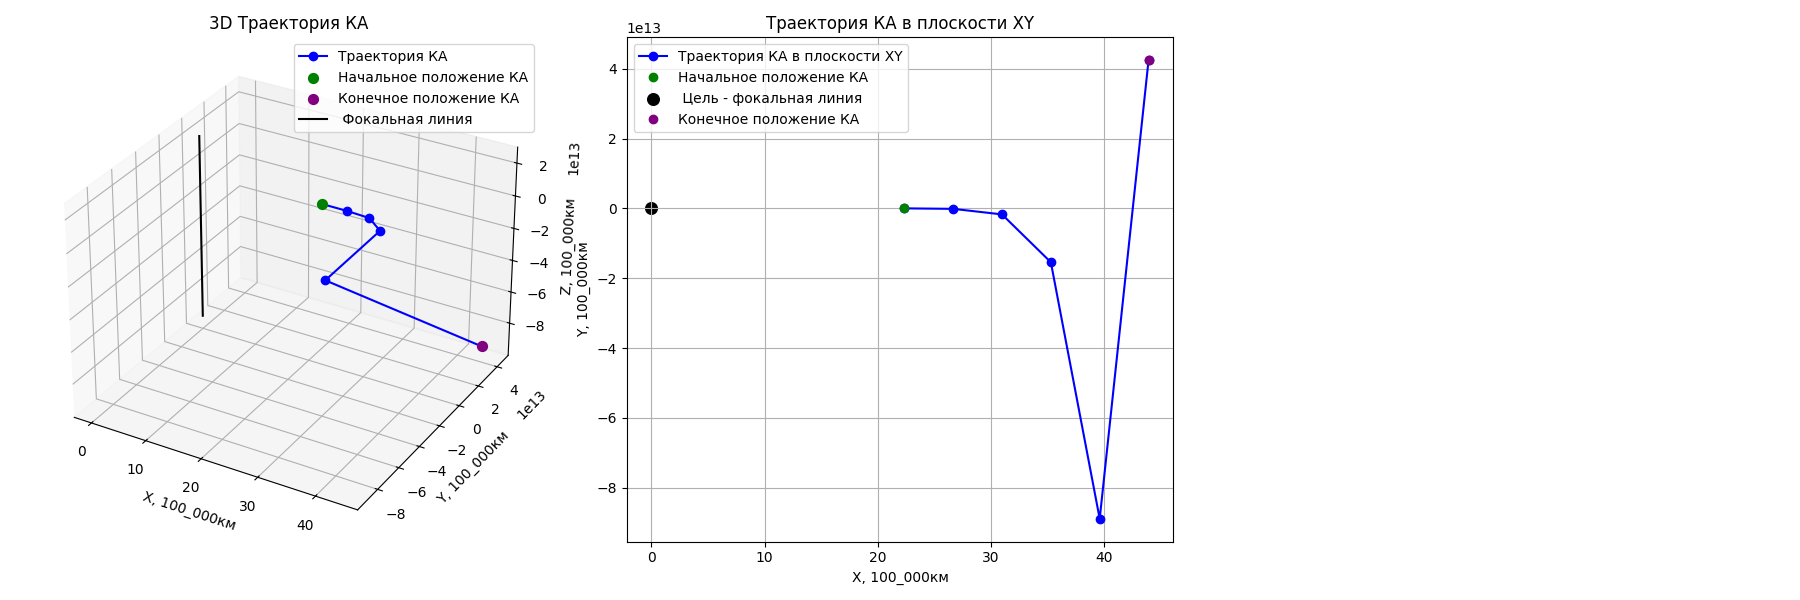

In [48]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Получение окружения и начальных наблюдений
vec_env = model.get_env()
obs = vec_env.reset()

# Инициализация списков для хранения данных
action_array = []
states_array = []
obs_array = []
rewards_array = []
reward_total = 0
reward_total_array = []

for i in range(n_imp):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = vec_env.step(action)
    
    if dones[0]:  # Если эпизод завершен
        obs_array.append(info[0]['terminal_observation'])
        rewards = np.array(info[0]['episode']['r'])
        reward_total_array.append(rewards)
        break

    reward_total += rewards
    obs_array.append(obs[0, :])
    rewards_array.append(rewards)
    reward_total_array.append(reward_total[0])
    action_array.append(action)
    states_array.append(_states)

# Преобразование списков в массивы
action_array = np.array(action_array)
states_array = np.array(states_array)
obs_array = np.array(obs_array)

# Извлекаем координаты из фазового вектора
x_array = obs_array[:, 0]  # Координата x
y_array = obs_array[:, 1]  # Координата y
z_array = obs_array[:, 2]  # Координата z

# Извлекаем компоненты скорости
vx_array = obs_array[:, 3]
vy_array = obs_array[:, 4]
vz_array = obs_array[:, 5]

# Создание графиков
fig = plt.figure(figsize=(18, 6))

# 3D-график траектории
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot(x_array, y_array, z_array, '-o', color='blue', label='Траектория КА')
ax1.scatter(x_array[0], y_array[0], z_array[0], color="green", label="Начальное положение КА", s=50)
ax1.scatter(x_array[-1], y_array[-1], z_array[-1], color="purple", label="Конечное положение КА", s=50)
ax1.plot([0, 0], [0, 0],[np.min(z_array), np.max(z_array)], '-', color='black', label=' Фокальная линия')
ax1.set_title('3D Траектория КА')
ax1.set_xlabel('X, 100_000км')
ax1.set_ylabel('Y, 100_000км')
ax1.set_zlabel('Z, 100_000км')
ax1.legend()

# 2D-график в плоскости (y, z)
ax2 = fig.add_subplot(132)
ax2.plot(x_array, y_array, '-o', color='blue', label='Траектория КА в плоскости XY')
ax2.plot(x_array[0], y_array[0], 'o', color="green", label="Начальное положение КА")
ax2.scatter([0.], [0.], color = 'black', s = 70, label = " Цель - фокальная линия")
ax2.plot(x_array[-1], y_array[-1], 'o', color="purple", label="Конечное положение КА")
ax2.set_title('Траектория КА в плоскости XY')
ax2.set_xlabel('X, 100_000км')
ax2.set_ylabel('Y, 100_000км')
ax2.legend()
ax2.grid()

# # График скоростей (Vy, Vx)
# ax3 = fig.add_subplot(133)
# ax3.plot(vz_array, '-o', color='red', label='Vx')
# ax3.plot(vy_array, '-o', color='blue', label='Vy')
# ax3.set_title('График скорости')
# ax3.set_xlabel('Шаги')
# ax3.set_ylabel('Скорость')
# ax3.legend()
# ax3.grid()

plt.tight_layout()
plt.show()
